In [27]:
import warnings
warnings.filterwarnings('ignore')

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import pandas_ta as ta
import seaborn as sns

In [28]:
dolar_df = pd.read_csv('./data/dolar_D_2307.csv')
dolar_df.set_index('Data', inplace=True)
dolar_df = dolar_df[::-1]
dolar_df

,Abertura,Máxima,Mínima,Fechamento,BOP,VOL,Compradores,Vendedores,Saldo
Data,,,,,,,,,
2014-03-05,3667.4988,3669.0542,3627.0599,3630.9483,-0.8704,3.097117e+10,0,0,0
2014-03-06,3620.8385,3639.5026,3604.5074,3638.7250,0.5111,5.893776e+10,0,0,0
2014-03-07,3635.6143,3678.3862,3633.2813,3664.3881,0.6379,5.799550e+10,0,0,0
2014-03-10,3664.3881,3687.7183,3641.8357,3678.3862,0.3051,5.786549e+10,0,0,0
2014-03-11,3685.3853,3705.6047,3659.7221,3698.6057,0.2881,6.058720e+10,0,0,0
...,...,...,...,...,...,...,...,...,...
2021-07-19,5168.5000,5265.5000,5159.5000,5259.0000,0.8538,7.681582e+10,128115,-123845,4270
2021-07-20,5250.0000,5301.0000,5208.5000,5228.0000,-0.2378,7.046589e+10,110000,-117505,-7505
2021-07-21,5238.0000,5283.5000,5187.0000,5194.5000,-0.4508,8.043548e+10,119365,-129670,-10305


In [29]:
# variação
dolar_df['Variação'] = dolar_df['Fechamento'].pct_change()

# médias
dolar_df['M20'] = ta.sma(dolar_df['Variação'], length=20)
dolar_df['M50'] = ta.sma(dolar_df['Variação'], length=50)
dolar_df['M200'] = ta.sma(dolar_df['Variação'], length=200)

# distancia média
dolar_df['Dist20'] = dolar_df['Variação'] - dolar_df['M20'] 
dolar_df['Dist50'] = dolar_df['Variação'] - dolar_df['M50']
dolar_df['Dist200'] = dolar_df['Variação'] - dolar_df['M200']

# classes 0(venda)/1(compra)
dolar_df['Classe'] = dolar_df['Variação'].apply([lambda x:1 if x >0 else 0])

# correr a classe 1 dia para poder gerar previsão
dolar_df['Classe'] = dolar_df['Classe'].shift(-1)
dolar_df.tail()


,Abertura,Máxima,Mínima,Fechamento,BOP,VOL,Compradores,Vendedores,Saldo,Variação,M20,M50,M200,Dist20,Dist50,Dist200,Classe
Data,,,,,,,,,,,,,,,,,
2021-07-19,5168.5,5265.5,5159.5,5259.0,0.8538,7.681582e+10,128115,-123845,4270,0.027048,0.001497,-0.000190,-0.000312,0.025552,0.027238,0.027360,0.0
2021-07-20,5250.0,5301.0,5208.5,5228.0,-0.2378,7.046589e+10,110000,-117505,-7505,-0.005895,0.001972,-0.000136,-0.000269,-0.007867,-0.005758,-0.005626,0.0
2021-07-21,5238.0,5283.5,5187.0,5194.5,-0.4508,8.043548e+10,119365,-129670,-10305,-0.006408,0.002215,-0.000207,-0.000349,-0.008622,-0.006201,-0.006059,1.0
2021-07-22,5186.5,5229.5,5173.5,5205.5,0.3393,4.981865e+10,86065,-84660,1405,0.002118,0.002225,-0.000146,-0.000427,-0.000107,0.002263,0.002544,0.0
2021-07-23,5203.5,5236.5,5163.0,5203.5,0.0000,5.767838e+10,95580,-97285,-1705,-0.000384,0.002744,-0.000477,-0.000406,-0.003128,0.000093,0.000022,NaN


In [30]:
dolar_df = dolar_df.dropna()

In [31]:
dolar_df.nunique()

Abertura       1574
Máxima         1577
Mínima         1578
Fechamento     1582
BOP            1449
VOL            1626
Compradores     992
Vendedores     1003
Saldo           921
Variação       1619
M20            1626
M50            1626
M200           1626
Dist20         1626
Dist50         1626
Dist200        1626
Classe            2
dtype: int64

In [32]:
# filtro dos valores para os diferentes de 0
dolar_df = dolar_df.loc[dolar_df['Compradores'] != 0]
dolar_df

,Abertura,Máxima,Mínima,Fechamento,BOP,VOL,Compradores,Vendedores,Saldo,Variação,M20,M50,M200,Dist20,Dist50,Dist200,Classe
Data,,,,,,,,,,,,,,,,,
2017-06-06,3734.8525,3736.5399,3703.3537,3708.9785,-0.7797,4.456790e+10,97950,-105830,-7880,-0.006329,0.001207,0.000598,-0.000207,-0.007536,-0.006927,-0.006123,0.0
2017-06-07,3712.3534,3717.4157,3693.2291,3697.7289,-0.6047,4.147236e+10,99765,-94740,5025,-0.003033,0.001452,0.000753,-0.000240,-0.004485,-0.003786,-0.002793,0.0
2017-06-08,3705.6036,3719.1031,3687.6043,3687.6043,-0.5714,4.030693e+10,86135,-96180,-10045,-0.002738,0.001755,0.000583,-0.000259,-0.004493,-0.003321,-0.002479,1.0
2017-06-09,3688.1668,3727.5403,3680.8546,3724.1654,0.7711,4.743102e+10,109490,-107195,2295,0.009915,0.002567,0.000708,-0.000261,0.007347,0.009207,0.010176,1.0
2017-06-12,3716.2907,3759.6015,3702.7912,3747.7895,0.5545,5.142668e+10,119305,-121080,-1775,0.006343,0.003068,0.000965,-0.000177,0.003276,0.005379,0.006521,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,5113.5000,5135.0000,5081.0000,5120.5000,0.1296,5.687428e+10,98750,-97705,1045,-0.000488,0.000967,-0.001007,-0.000337,-0.001455,0.000519,-0.000151,1.0
2021-07-19,5168.5000,5265.5000,5159.5000,5259.0000,0.8538,7.681582e+10,128115,-123845,4270,0.027048,0.001497,-0.000190,-0.000312,0.025552,0.027238,0.027360,0.0
2021-07-20,5250.0000,5301.0000,5208.5000,5228.0000,-0.2378,7.046589e+10,110000,-117505,-7505,-0.005895,0.001972,-0.000136,-0.000269,-0.007867,-0.005758,-0.005626,0.0


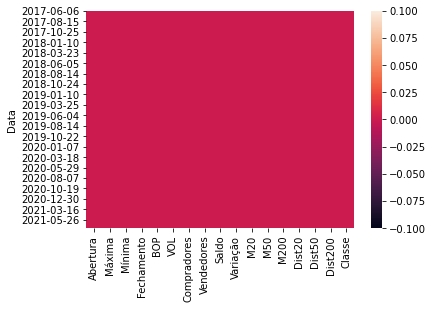

In [33]:
sns.heatmap(dolar_df.isnull());

In [34]:
df_visual = dolar_df[['Variação','Dist200','Dist50','Dist20','M200','M50','M20','Saldo',]]

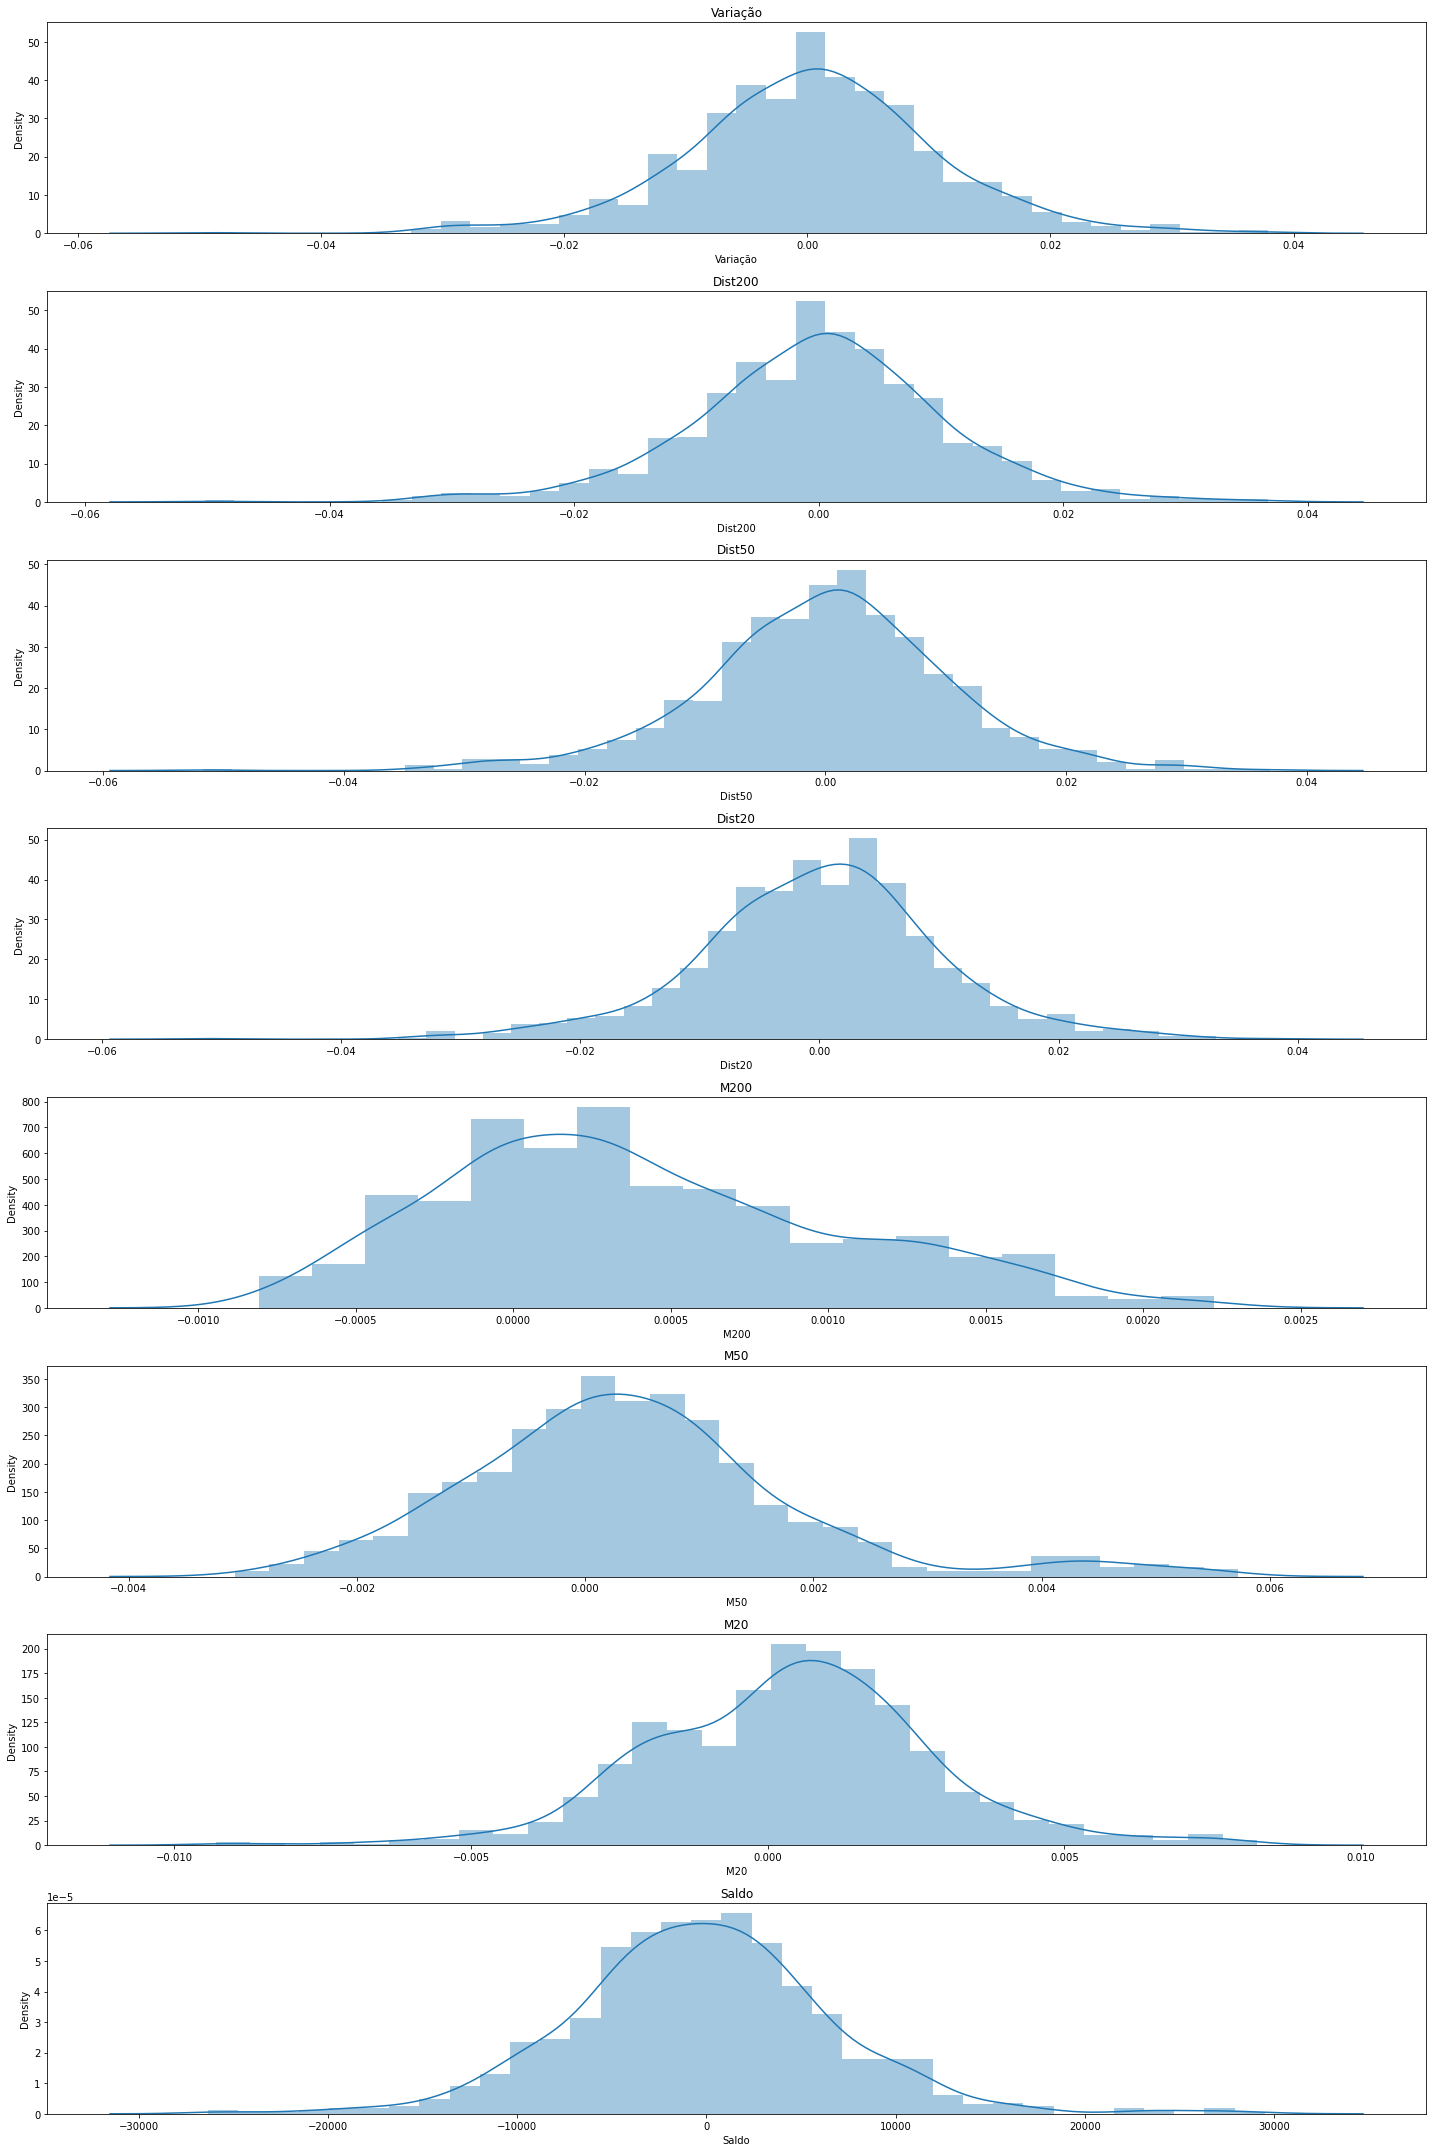

In [35]:
import warnings
warnings.filterwarnings("ignore")

# plotagem de graficos de todas as colunas
plt.figure(figsize=(20, 30))
for i in range(len(df_visual.columns)):
    plt.subplot( 8 , 1 , i + 1 )
    sns.distplot(df_visual[df_visual.columns[i]],)
    plt.title(df_visual.columns[i])
plt.tight_layout();

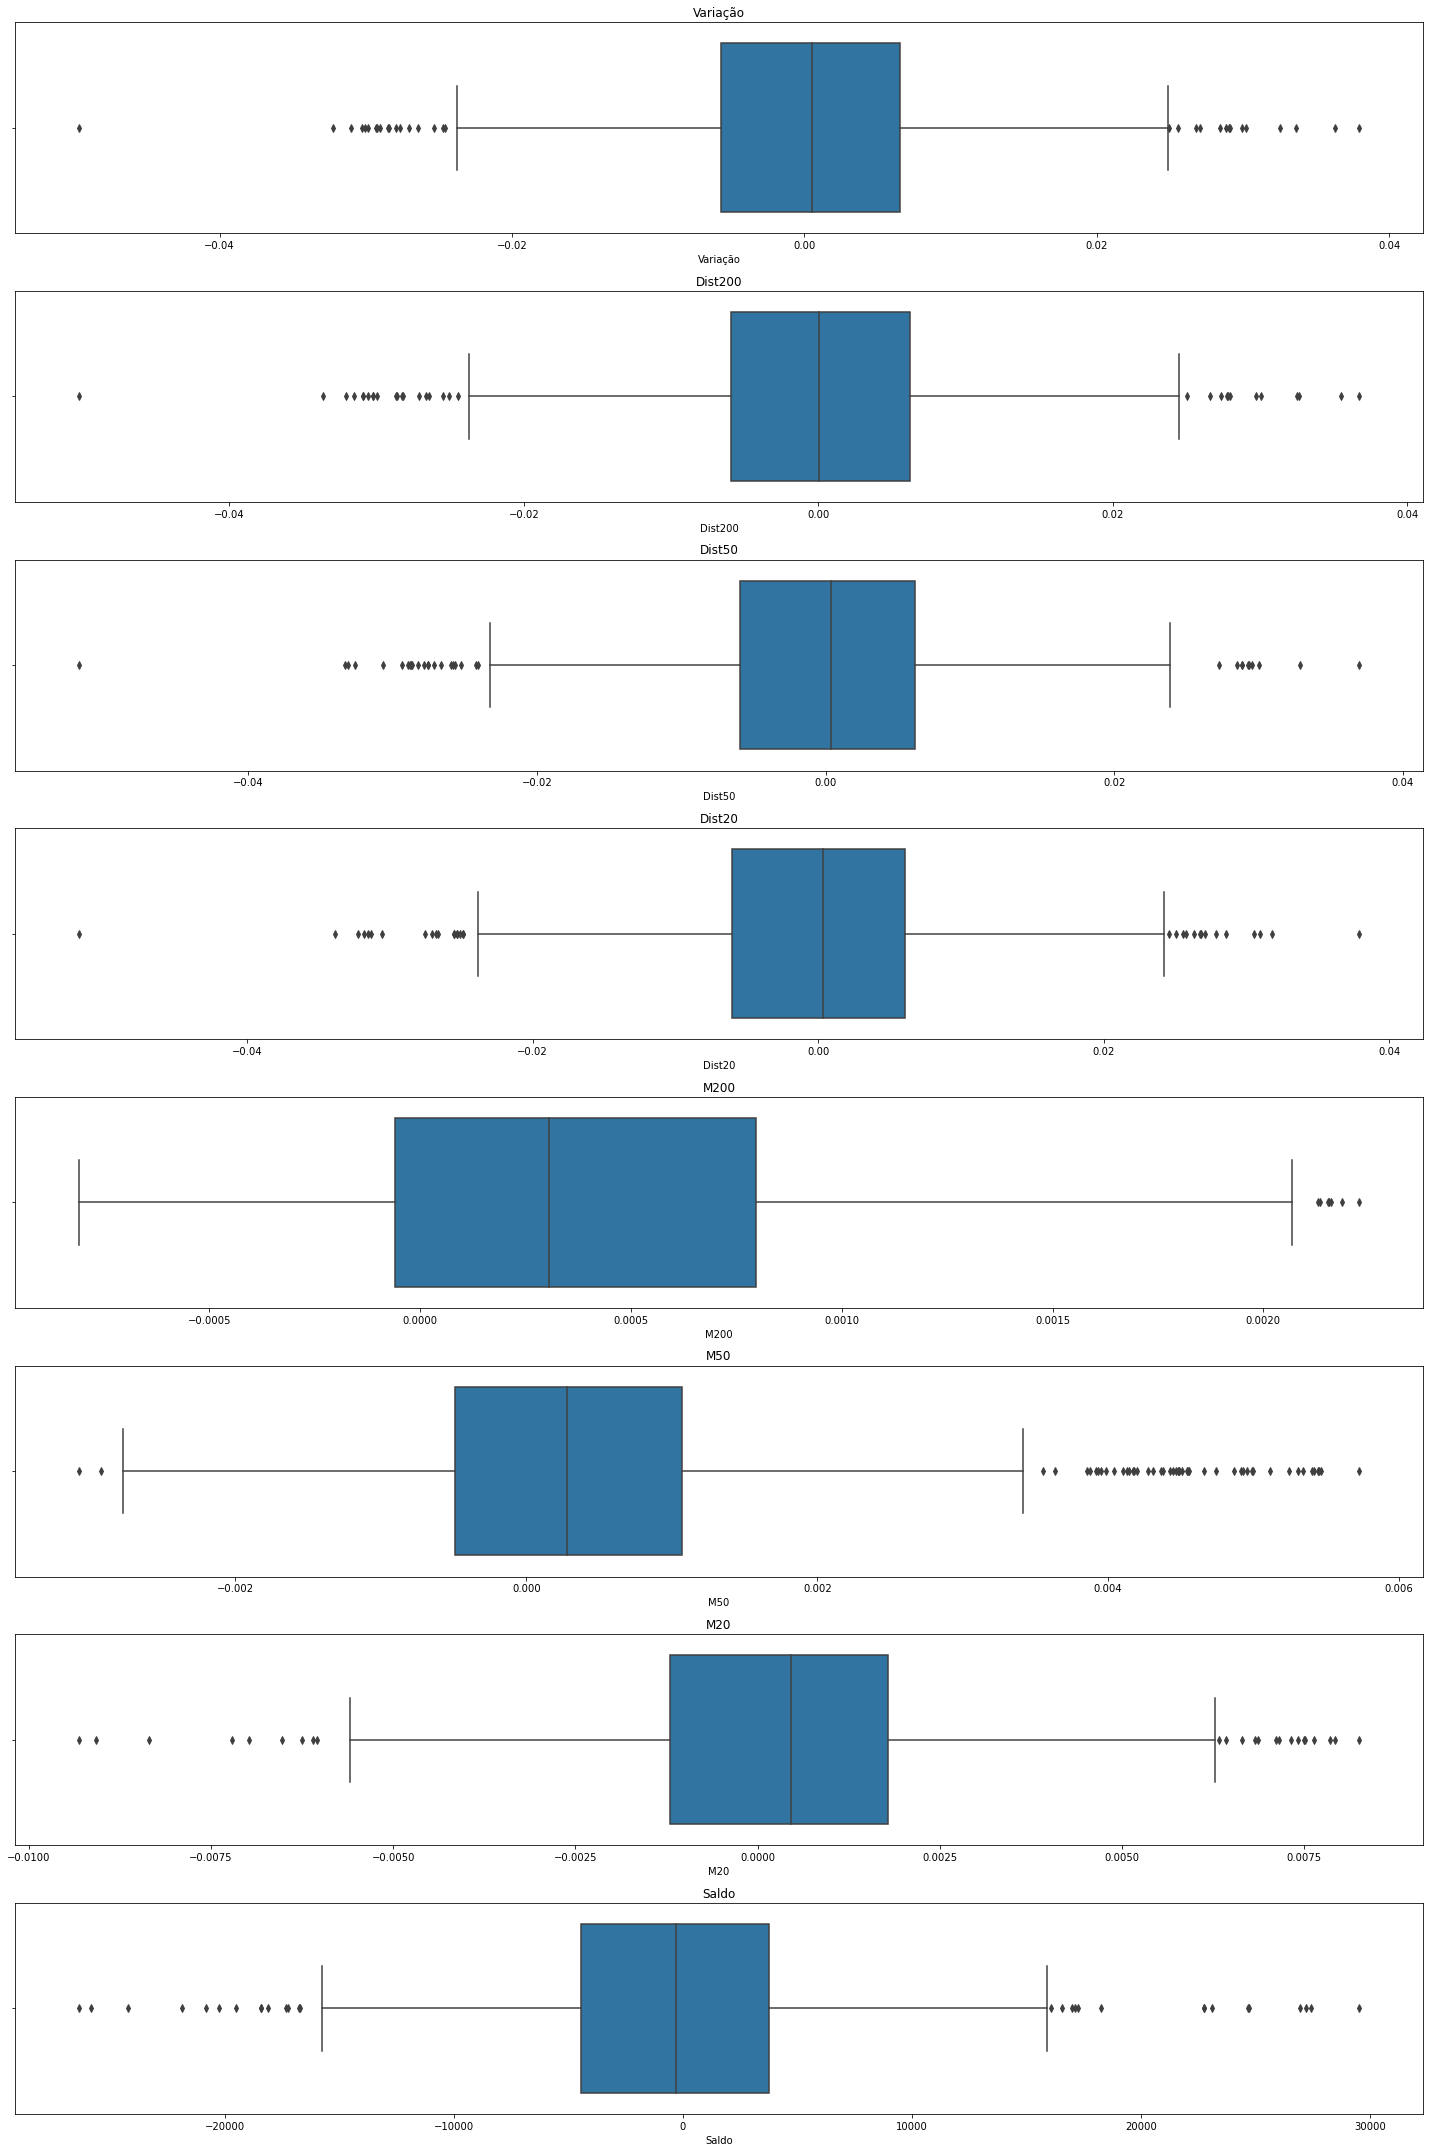

In [36]:
plt.figure(figsize=(20, 30))
for i in range(len(df_visual.columns)):
    plt.subplot( 8 , 1 , i + 1 )
    sns.boxplot(df_visual[df_visual.columns[i]],)
    plt.title(df_visual.columns[i])
plt.tight_layout();

In [37]:
correlação = dolar_df.corr()

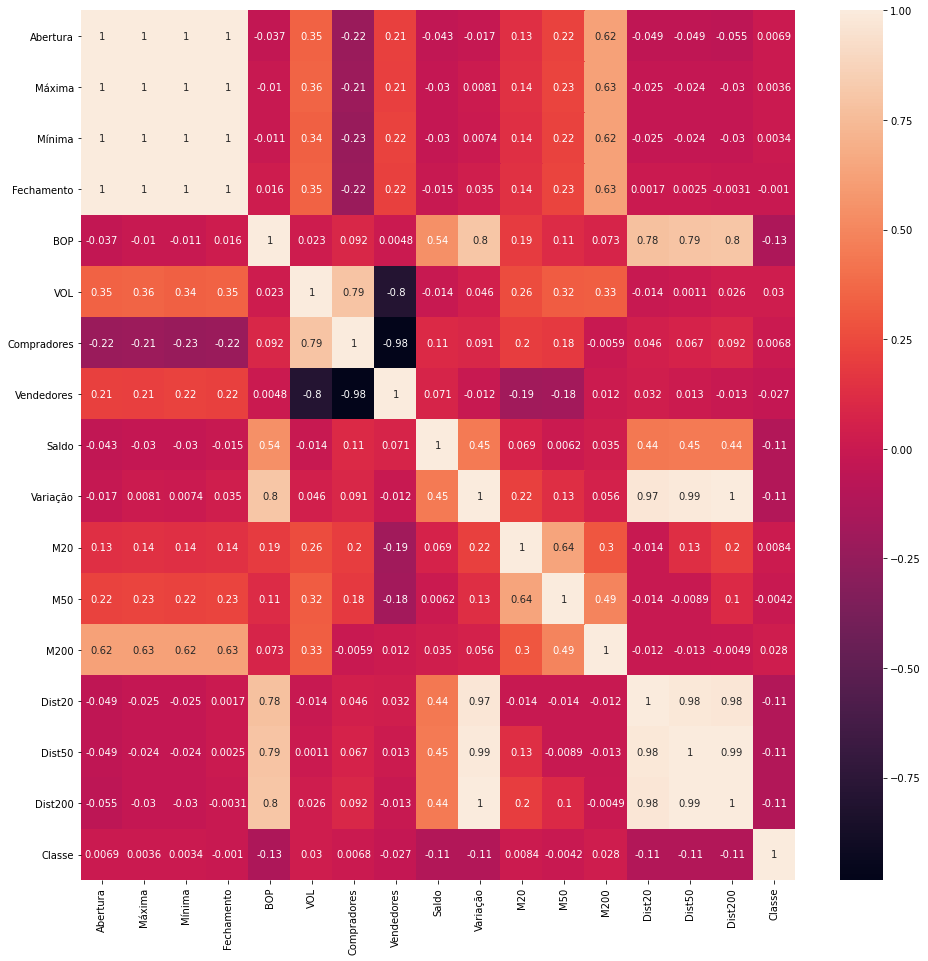

In [38]:
plt.figure(figsize=(16,16))
sns.heatmap(correlação, annot=True);

In [39]:
dolar_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1020 entries, 2017-06-06 to 2021-07-22
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Abertura     1020 non-null   float64
 1   Máxima       1020 non-null   float64
 2   Mínima       1020 non-null   float64
 3   Fechamento   1020 non-null   float64
 4   BOP          1020 non-null   float64
 5   VOL          1020 non-null   float64
 6   Compradores  1020 non-null   int64  
 7   Vendedores   1020 non-null   int64  
 8   Saldo        1020 non-null   int64  
 9   Variação     1020 non-null   float64
 10  M20          1020 non-null   float64
 11  M50          1020 non-null   float64
 12  M200         1020 non-null   float64
 13  Dist20       1020 non-null   float64
 14  Dist50       1020 non-null   float64
 15  Dist200      1020 non-null   float64
 16  Classe       1020 non-null   float64
dtypes: float64(14), int64(3)
memory usage: 143.4+ KB


In [40]:
# dataframe com atributos numericos
df_teste = dolar_df[['Variação','Dist200','Dist50','Dist20','M200','M50','M20','Saldo',]] # 'Vendedores','Compradores','VOL','BOP','Fechamento','Mínima','Máxima','Abertura'
df_teste

,Variação,Dist200,Dist50,Dist20,M200,M50,M20,Saldo
Data,,,,,,,,
2017-06-06,-0.006329,-0.006123,-0.006927,-0.007536,-0.000207,0.000598,0.001207,-7880
2017-06-07,-0.003033,-0.002793,-0.003786,-0.004485,-0.000240,0.000753,0.001452,5025
2017-06-08,-0.002738,-0.002479,-0.003321,-0.004493,-0.000259,0.000583,0.001755,-10045
2017-06-09,0.009915,0.010176,0.009207,0.007347,-0.000261,0.000708,0.002567,2295
2017-06-12,0.006343,0.006521,0.005379,0.003276,-0.000177,0.000965,0.003068,-1775
...,...,...,...,...,...,...,...,...
2021-07-16,-0.000488,-0.000151,0.000519,-0.001455,-0.000337,-0.001007,0.000967,1045
2021-07-19,0.027048,0.027360,0.027238,0.025552,-0.000312,-0.000190,0.001497,4270
2021-07-20,-0.005895,-0.005626,-0.005758,-0.007867,-0.000269,-0.000136,0.001972,-7505


In [41]:
dolar_df

,Abertura,Máxima,Mínima,Fechamento,BOP,VOL,Compradores,Vendedores,Saldo,Variação,M20,M50,M200,Dist20,Dist50,Dist200,Classe
Data,,,,,,,,,,,,,,,,,
2017-06-06,3734.8525,3736.5399,3703.3537,3708.9785,-0.7797,4.456790e+10,97950,-105830,-7880,-0.006329,0.001207,0.000598,-0.000207,-0.007536,-0.006927,-0.006123,0.0
2017-06-07,3712.3534,3717.4157,3693.2291,3697.7289,-0.6047,4.147236e+10,99765,-94740,5025,-0.003033,0.001452,0.000753,-0.000240,-0.004485,-0.003786,-0.002793,0.0
2017-06-08,3705.6036,3719.1031,3687.6043,3687.6043,-0.5714,4.030693e+10,86135,-96180,-10045,-0.002738,0.001755,0.000583,-0.000259,-0.004493,-0.003321,-0.002479,1.0
2017-06-09,3688.1668,3727.5403,3680.8546,3724.1654,0.7711,4.743102e+10,109490,-107195,2295,0.009915,0.002567,0.000708,-0.000261,0.007347,0.009207,0.010176,1.0
2017-06-12,3716.2907,3759.6015,3702.7912,3747.7895,0.5545,5.142668e+10,119305,-121080,-1775,0.006343,0.003068,0.000965,-0.000177,0.003276,0.005379,0.006521,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-16,5113.5000,5135.0000,5081.0000,5120.5000,0.1296,5.687428e+10,98750,-97705,1045,-0.000488,0.000967,-0.001007,-0.000337,-0.001455,0.000519,-0.000151,1.0
2021-07-19,5168.5000,5265.5000,5159.5000,5259.0000,0.8538,7.681582e+10,128115,-123845,4270,0.027048,0.001497,-0.000190,-0.000312,0.025552,0.027238,0.027360,0.0
2021-07-20,5250.0000,5301.0000,5208.5000,5228.0000,-0.2378,7.046589e+10,110000,-117505,-7505,-0.005895,0.001972,-0.000136,-0.000269,-0.007867,-0.005758,-0.005626,0.0


In [42]:
# normalização dos valores para os atributos com valores maiores para não ter pesos diferentes no algoritmo
scaler = MinMaxScaler()
X = scaler.fit_transform(df_teste)

In [43]:
X

array([[0.49429324, 0.50705568, 0.50510806, ..., 0.41726824, 0.59874769,
        0.33061918],
       [0.53195262, 0.54535812, 0.54053921, ..., 0.43493157, 0.61273034,
        0.56156049],
       [0.53532333, 0.54897241, 0.54578931, ..., 0.41556053, 0.62996948,
        0.29187545],
       ...,
       [0.49925728, 0.5127669 , 0.51829023, ..., 0.33380789, 0.64233416,
        0.33732999],
       [0.49339426, 0.50779024, 0.5133022 , ..., 0.32573548, 0.65615152,
        0.28722262],
       [0.59080246, 0.60676788, 0.60878663, ..., 0.33272356, 0.65672863,
        0.49677881]])

In [44]:
y = dolar_df['Classe']
y

Data
2017-06-06    0.0
2017-06-07    0.0
2017-06-08    1.0
2017-06-09    1.0
2017-06-12    0.0
             ... 
2021-07-16    1.0
2021-07-19    0.0
2021-07-20    0.0
2021-07-21    1.0
2021-07-22    0.0
Name: Classe, Length: 1020, dtype: float64

In [45]:
# separação da base de dados em treino e teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25)

In [46]:
# tamanho dos dados após divisão
X_treino.shape, y_treino.shape

((765, 8), (765,))

In [47]:
# importação da biblioteca de regressão logistica
from sklearn.linear_model import LogisticRegression

In [48]:
# treinamento dos dados
RLmodel = LogisticRegression()
RLmodel.fit(X_treino, y_treino)

LogisticRegression()

In [49]:
# teste de previsões
RLprev = RLmodel.predict(X_teste)
RLprev

array([0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0.

In [50]:
# valores corretos para comparação
y_teste

Data
2019-12-20    0.0
2017-11-14    0.0
2020-12-22    1.0
2021-05-28    0.0
2017-06-20    1.0
             ... 
2020-04-22    1.0
2020-01-06    1.0
2017-10-23    1.0
2019-02-05    1.0
2019-02-07    1.0
Name: Classe, Length: 255, dtype: float64

In [51]:
# calculo do accuracy
from sklearn.metrics import accuracy_score

In [52]:
# uso dos valores corretos e das previsões
RLa = accuracy_score(y_teste, RLprev)
print(f'Accuracy de {RLa:2.2%} ')

Accuracy de 53.33% 


In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
cm = confusion_matrix(y_teste, RLprev)
cm

array([[40, 90],
       [29, 96]], dtype=int64)

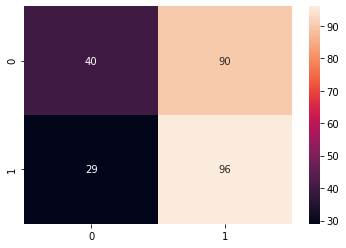

In [55]:
# visualização grafica
# classe 0 não saem da empresa 
# calsse 1 saem da empresa
sns.heatmap(cm, annot=True);

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
# criação do modelo Random Forest
RFmodel = RandomForestClassifier()

In [58]:
# treinamento
RFmodel.fit(X_treino, y_treino)

RandomForestClassifier()

In [59]:
# previsão usando Random Forest
RFprev = RFmodel.predict(X_teste)

In [60]:
# accuracy do modelo
RLa = accuracy_score(y_teste, RFprev)
print(f'Accuracy de {RLa:2.2%} ')

Accuracy de 48.63% 


In [61]:
# usando bibliotecas sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report 

In [62]:
# analise usando outros indicadores
print(classification_report(y_teste, RFprev))

              precision    recall  f1-score   support

         0.0       0.49      0.38      0.43       130
         1.0       0.48      0.60      0.53       125

    accuracy                           0.49       255
   macro avg       0.49      0.49      0.48       255
weighted avg       0.49      0.49      0.48       255



In [83]:
X_teste.shape

(255, 8)

In [87]:
# criação do modelo 
RN_model = tf.keras.models.Sequential()
RN_model.add(tf.keras.layers.Dense(units = 50, activation='relu', input_shape=(8,))) #relu valores menores que zero retorna zero
RN_model.add(tf.keras.layers.Dense(units = 50, activation = 'relu'))
RN_model.add(tf.keras.layers.Dense(units = 50, activation = 'relu'))
RN_model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

In [88]:
# verificação do modelo
RN_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                450       
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [74]:
RN_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [75]:
RN_model.fit(X_treino, y_treino, epochs=200)

Epoch 1/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5124
Epoch 2/200
24/24 [==============================] - 0s 946us/step - loss: 0.6908 - accuracy: 0.5373
Epoch 3/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6907 - accuracy: 0.5333
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5569
Epoch 5/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6881 - accuracy: 0.5516
Epoch 6/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6906 - accuracy: 0.5255
Epoch 7/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5307
Epoch 8/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6866 - accuracy: 0.5451
Epoch 9/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6871 - accuracy: 0.5529
Epoch 10/200
24/24 [==============================] - 0s 1ms/step - loss: 0.6844 - accuracy: 0.5477
Epoch 1

In [76]:
RNprev = RN_model.predict(X_teste)
RNprev

array([[1.64197862e-01],
       [1.80497587e-01],
       [4.79901671e-01],
       [6.49044514e-01],
       [2.46134967e-01],
       [2.90377438e-01],
       [7.71430612e-01],
       [8.78495455e-01],
       [4.93315727e-01],
       [4.50239480e-01],
       [4.16325718e-01],
       [6.06518984e-01],
       [4.84766632e-01],
       [7.15178728e-01],
       [6.53715730e-01],
       [6.94426417e-01],
       [2.82412529e-01],
       [9.99155521e-01],
       [6.32304192e-01],
       [5.94254255e-01],
       [1.48690641e-01],
       [5.47854483e-01],
       [6.99801505e-01],
       [1.86996520e-01],
       [5.02731323e-01],
       [2.54675090e-01],
       [5.11069119e-01],
       [5.56531310e-01],
       [5.65711260e-01],
       [6.39963269e-01],
       [5.58173537e-01],
       [9.03907418e-01],
       [1.31233722e-01],
       [7.86882043e-02],
       [5.05449295e-01],
       [1.68089300e-01],
       [7.40936756e-01],
       [5.64602911e-01],
       [5.90485990e-01],
       [8.30126405e-02],


In [77]:
RNprev = (RNprev >= 0.50)
RNprev

array([[False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [

In [78]:
cm = confusion_matrix(y_teste, RNprev)
cm

array([[75, 55],
       [57, 68]], dtype=int64)

In [79]:
print(classification_report(y_teste, RNprev))

              precision    recall  f1-score   support

         0.0       0.57      0.58      0.57       130
         1.0       0.55      0.54      0.55       125

    accuracy                           0.56       255
   macro avg       0.56      0.56      0.56       255
weighted avg       0.56      0.56      0.56       255



In [99]:
#reshape do input(colocando os dados temporais em features):
x_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))#pega dataset x_treino e coloca no formato
#[n_amostras, n_timesteps, nfeatures]. o resultado dessa operação será os dados do datasetx_treino com essas 3 dimenções.
x_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [108]:
print(X_teste.shape)

(255, 8)


In [102]:
# LSTM
# criação do modelo 
RN_model = tf.keras.models.Sequential()
RN_model.add(tf.keras.layers.LSTM(units=50,batch_input_shape = (10, X_treino.shape[0], X_treino.shape[1]),  stateful = True, return_sequences = True)) 
RN_model.add(tf.keras.layers.LSTM(units=50,batch_input_shape = (10, X_treino.shape[0], X_treino.shape[1]),  stateful = True, return_sequences = True))
RN_model.add(tf.keras.layers.LSTM(units=50,batch_input_shape = (10, X_treino.shape[0], X_treino.shape[1]),  stateful = True,))
RN_model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

In [103]:
RN_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (10, 765, 50)             11800     
_________________________________________________________________
lstm_13 (LSTM)               (10, 765, 50)             20200     
_________________________________________________________________
lstm_14 (LSTM)               (10, 50)                  20200     
_________________________________________________________________
dense_18 (Dense)             (10, 1)                   51        
Total params: 52,251
Trainable params: 52,251
Non-trainable params: 0
_________________________________________________________________


In [104]:
RN_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [110]:
# RN_model.fit(X_treino, y_treino, epochs=200)
# problema no treinamento com a entrada tamanho do shape